导入一些必要的包

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns

In [4]:
labels_dataframe = pd.read_csv('leaves_data/train.csv')
labels_dataframe.head(5)

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [5]:
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/1713.jpg,maclura_pomifera
freq,1,353


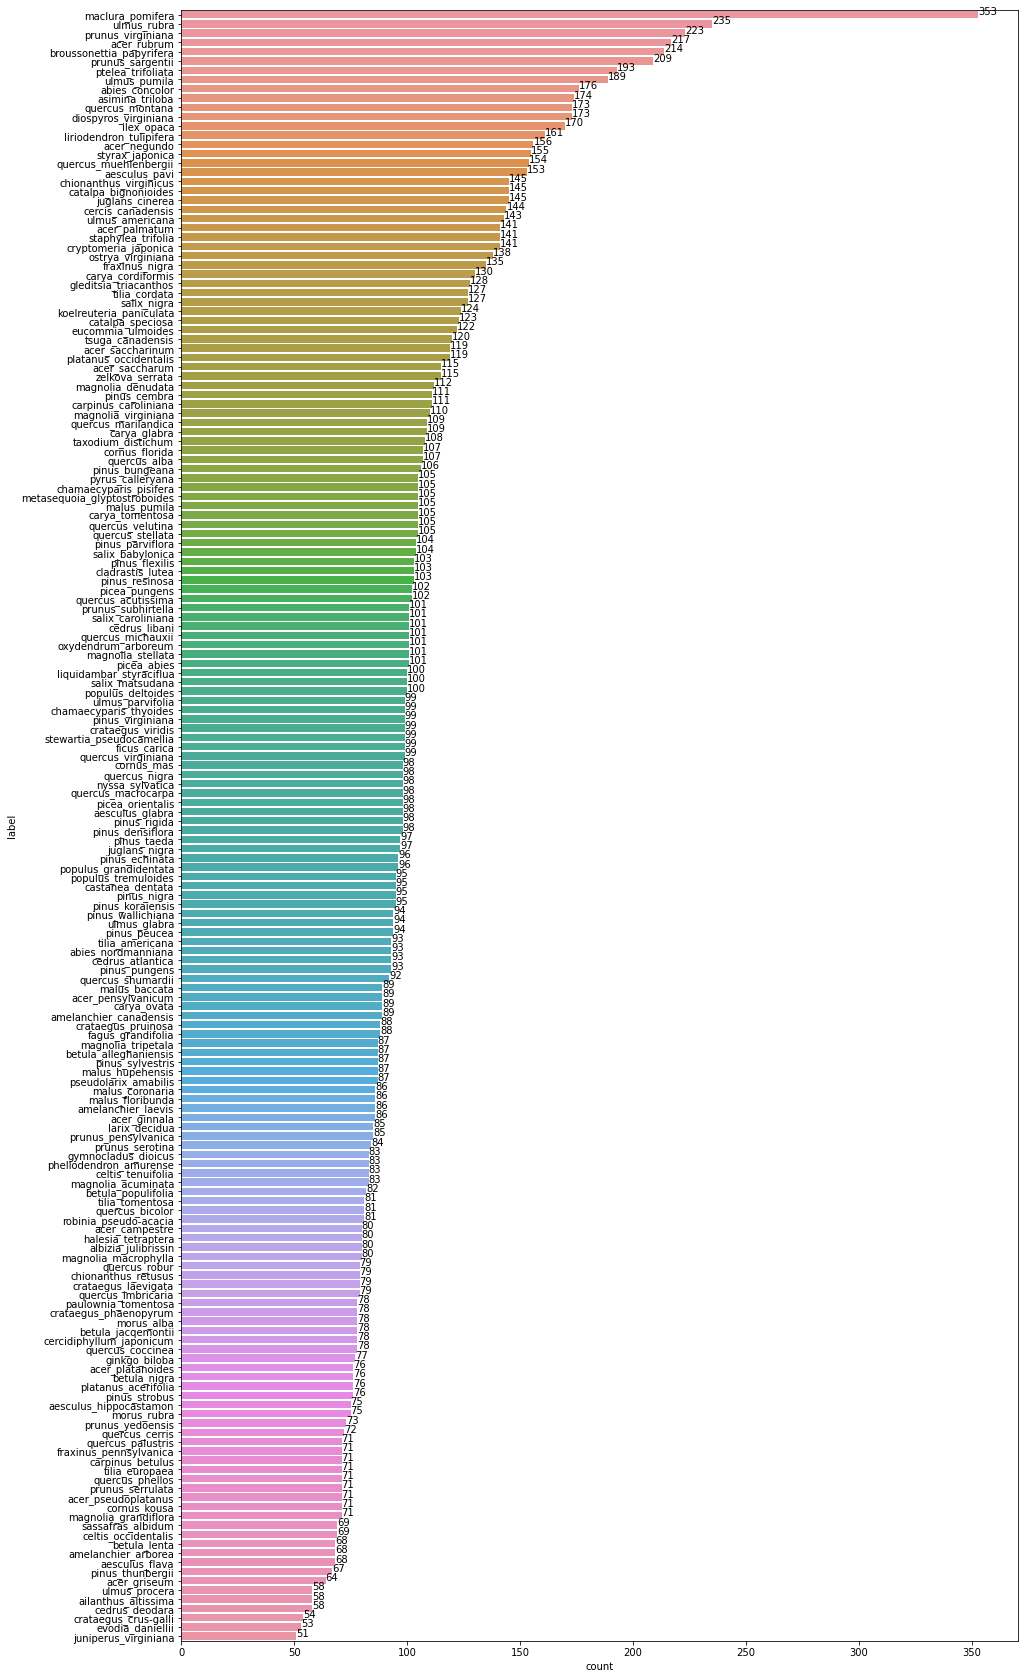

In [6]:
#function to show bar length

def barw(ax): 
    
    for p in ax.patches:
        val = p.get_width() #height of the bar
        x = p.get_x()+ p.get_width() # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))
        
#finding top leaves

plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels_dataframe['label'],order=labels_dataframe['label'].value_counts().index)
barw(ax0)
plt.show()

In [7]:
# Create list of alphabetically sorted labels.
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
print(n_classes)
leaves_labels[:10]

176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [21]:
#Map each label string to an integer label.
class_to_num = dict(zip(leaves_labels, range(n_classes)))
num_to_class = {v : k for k, v in class_to_num.items()}
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [38]:
#建立自己的dataset
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.1, resize_height=256, resize_width=256):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
        """
        
        # 需要调整后的照片尺寸，我这里每张图片的大小尺寸不一致#
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        # 读取 csv 文件
        # 利用pandas读取csv文件
        self.data_info = pd.read_csv(csv_path, header=None)  #header=None是去掉表头部分
        # 计算 length
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            # 第一列包含图像文件的名称
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])  #self.data_info.iloc[1:,0]表示读取第一列，从第二行开始到train_len
            # 第二列是图像的 label
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)

        #如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
#         if img_as_img.mode != 'L':
#             img_as_img = img_as_img.convert('L')

        #设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
#                 transforms.RandomHorizontalFlip(p=0.5),   #随机水平翻转 选择一个概率
#                 transforms.RandomRotation(45),            #随机旋转，-45到45度之间随机选
                transforms.ToTensor()
            ])
        else:
            # valid和test不做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len


In [39]:
train_path = 'leaves_data/train.csv'
test_path = 'leaves_data/test.csv'
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = 'leaves_data/'

train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')
print(train_dataset)
print(val_dataset)
print(test_dataset)

Finished reading the train set of Leaves Dataset (16516 samples found)
Finished reading the valid set of Leaves Dataset (1837 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


In [40]:
print(len(train_dataset))
print(len(val_dataset))

16516
1837


In [41]:
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=8, 
        shuffle=True,
        num_workers=5
    )

val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=5
    )
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=8, 
        shuffle=False,
        num_workers=5
    )
print(test_loader)

In [42]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)

    return image

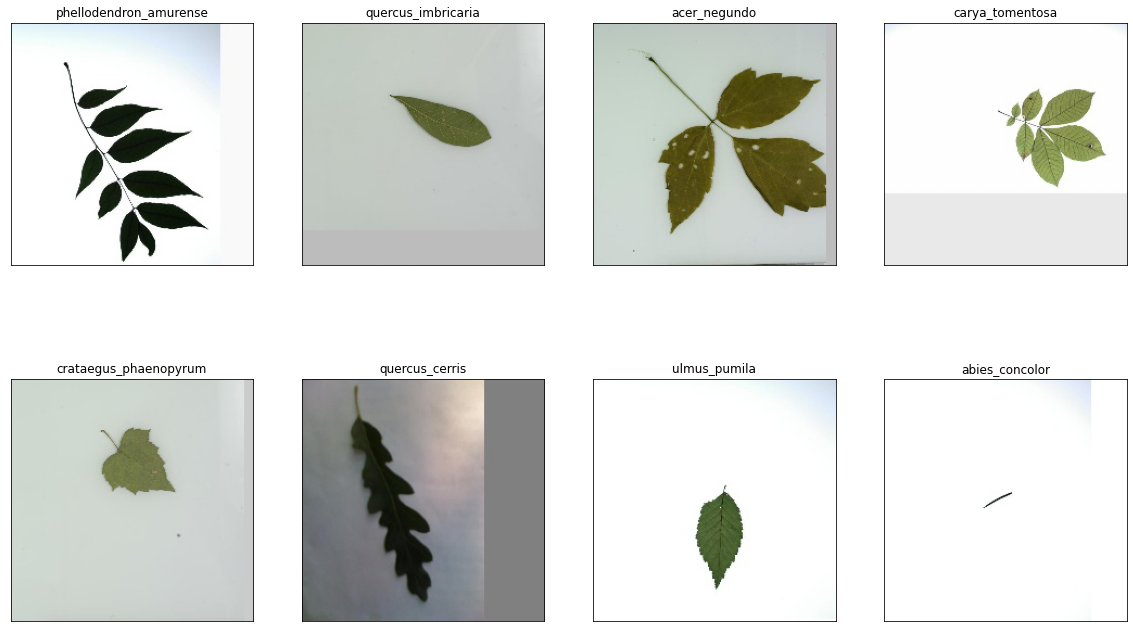

In [43]:
fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(train_loader)
inputs, classes = dataiter.next()


for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [147]:
#check device
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

cuda


In [173]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False

def res_model(num_classes, feature_extract = False, use_pretrained=True):

    model_ft = models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

In [174]:
model = res_model(176)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/yaohuifeng/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [175]:
learning_rate = 1e-3
weight_decay = 1e-3
num_epoch = 20
model_path = './model/pre_res_model.ckpt'

In [176]:
## train

# Initialize a model, and put it on the device specified.
model = model.to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

# The number of training epochs.
n_epochs = num_epoch

best_acc = 0.0
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train() 
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)
        
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Update the parameters with computed gradients.
        optimizer.step()
        
        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))
            
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    # if the model improves, save a checkpoint at this epoch
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 001/020 ] loss = 4.75528, acc = 0.02410


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 001/020 ] loss = 4.51100, acc = 0.03568
saving model with acc 0.036


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 002/020 ] loss = 4.10868, acc = 0.05569


100%|██████████| 459/459 [00:05<00:00, 86.02it/s]


[ Valid | 002/020 ] loss = 3.84673, acc = 0.08796


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.088


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 003/020 ] loss = 3.74938, acc = 0.09879


100%|██████████| 459/459 [00:05<00:00, 86.29it/s] 


[ Valid | 003/020 ] loss = 3.47718, acc = 0.12337


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.123


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 004/020 ] loss = 3.40810, acc = 0.14093


100%|██████████| 459/459 [00:05<00:00, 87.77it/s] 


[ Valid | 004/020 ] loss = 3.20359, acc = 0.16993


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.170


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 005/020 ] loss = 3.13820, acc = 0.18335


100%|██████████| 459/459 [00:05<00:00, 86.72it/s]


[ Valid | 005/020 ] loss = 2.88187, acc = 0.22386


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.224


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 006/020 ] loss = 2.93941, acc = 0.21548


100%|██████████| 459/459 [00:05<00:00, 83.83it/s]


[ Valid | 006/020 ] loss = 2.71923, acc = 0.25272


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.253


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 007/020 ] loss = 2.77114, acc = 0.24871


100%|██████████| 459/459 [00:05<00:00, 88.11it/s]


[ Valid | 007/020 ] loss = 2.66700, acc = 0.26607


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.266


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 008/020 ] loss = 2.63882, acc = 0.28513


100%|██████████| 459/459 [00:05<00:00, 89.04it/s] 


[ Valid | 008/020 ] loss = 2.60957, acc = 0.28486


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.285


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 009/020 ] loss = 2.52084, acc = 0.30923


100%|██████████| 459/459 [00:05<00:00, 87.47it/s]


[ Valid | 009/020 ] loss = 2.35677, acc = 0.33606


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.336


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 010/020 ] loss = 2.40661, acc = 0.33585


100%|██████████| 459/459 [00:05<00:00, 87.92it/s]


[ Valid | 010/020 ] loss = 2.25406, acc = 0.34450


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.344


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 011/020 ] loss = 2.31633, acc = 0.35614


100%|██████████| 459/459 [00:05<00:00, 90.64it/s] 


[ Valid | 011/020 ] loss = 2.09972, acc = 0.38889


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.389


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 012/020 ] loss = 2.23772, acc = 0.37657


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 012/020 ] loss = 2.23855, acc = 0.36356


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 013/020 ] loss = 2.16971, acc = 0.39263


100%|██████████| 459/459 [00:05<00:00, 89.09it/s]


[ Valid | 013/020 ] loss = 2.10943, acc = 0.39352


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.394


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 014/020 ] loss = 2.10790, acc = 0.40714


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 014/020 ] loss = 2.22757, acc = 0.36356


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 015/020 ] loss = 2.05742, acc = 0.41612


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 015/020 ] loss = 2.11871, acc = 0.38916


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 016/020 ] loss = 2.01360, acc = 0.42872


100%|██████████| 459/459 [00:05<00:00, 87.91it/s] 


[ Valid | 016/020 ] loss = 2.02246, acc = 0.40196


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.402


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 017/020 ] loss = 1.97088, acc = 0.44315


100%|██████████| 459/459 [00:05<00:00, 90.30it/s] 


[ Valid | 017/020 ] loss = 1.94197, acc = 0.42593


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.426


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 018/020 ] loss = 1.92680, acc = 0.45084


  0%|          | 0/1836 [00:00<?, ?it/s]

[ Valid | 018/020 ] loss = 2.18781, acc = 0.37881


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 019/020 ] loss = 1.89515, acc = 0.46072


100%|██████████| 459/459 [00:05<00:00, 88.22it/s] 


[ Valid | 019/020 ] loss = 1.86037, acc = 0.45643


  0%|          | 0/1836 [00:00<?, ?it/s]

saving model with acc 0.456


  0%|          | 0/459 [00:00<?, ?it/s]

[ Train | 020/020 ] loss = 1.86302, acc = 0.46841


100%|██████████| 459/459 [00:05<00:00, 88.79it/s] 

[ Valid | 020/020 ] loss = 3.08920, acc = 0.23883


In [177]:
saveFileName = './result/my_test.csv'

In [178]:
num_to_class = {v : k for k, v in class_to_num.items()}

In [179]:
## predict
model = res_model(176)

# create model and load weights from checkpoint
model = model.to(device)
model.load_state_dict(torch.load(model_path))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []
# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    
    imgs = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    
    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

preds = []
for i in predictions:
    preds.append(num_to_class[i])

test_data = pd.read_csv('leaves_data/test.csv')
test_data['label'] = pd.Series(preds)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(saveFileName, index=False)
print("Done!!!!!!!!!!!!!!!!!!!!!!!!!!!")

100%|██████████| 1100/1100 [00:10<00:00, 105.19it/s]

Done!!!!!!!!!!!!!!!!!!!!!!!!!!!
